In [1]:
import pandas as pd
import re
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import column_or_1d
import numpy as np
import pickle
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from xgboost import XGBClassifier

In [2]:
xgb.__version__

'0.90'

In [3]:
df_train_info = pd.read_csv('/content/info_train.csv') 
df_train_work = pd.read_csv('/content/work_train.csv') 
df_train_label = pd.read_csv('/content/label_train.csv') 
df_test_info = pd.read_csv('/content/info_test.csv')  
df_test_work = pd.read_csv('/content/work_test.csv')  
df_test_label = pd.read_csv('/content/label_test.csv')

In [4]:
df_train_info.head()

,bithYear,gender,address,id_bh
0,1971,MALE,hà Nội,113039360
1,1993,FEMALE,Thành phố Hà Nội,116074930
2,1977,MALE,NaN,203060233
3,1996,FEMALE,NaN,131373210
4,1971,MALE,NaN,198079441


In [5]:
df_train_work.head()

,id,id_bh,id_management,id_office,company_type,job/role,from_date,to_date,employee_lv,address
0,1,113039360,106,TF2212F,-1,Giám đốc,20130100,20151200,7.0,Hà Nội
1,1,113039360,106,TF2212F,-1,Giám đốc,20160100,20220400,10.0,Hà Nội
2,2,116074930,102,TB16010,-1,Nhân viên lễ tân,20160600,20161200,7.0,Hà Nội
3,2,116074930,102,TB16010,-1,Nhân viên lễ tân,20170100,20170300,8.0,Hà Nội
4,2,116074930,102,NaN,-1,NaN,20170400,20170700,-1.0,NaN


In [6]:
df_train_label.head()

,id_bh,label
0,4024579106,4
1,4026098901,3
2,8304005480,6
3,4025308121,2
4,2610012169,2


# Khảo sát dữ liệu

In [7]:
df_train = pd.merge(left=df_train_work, right=df_train_info, how='left', on='id_bh')
df = pd.merge(left=df_train, right=df_train_label, how='left', on='id_bh')

In [8]:
df_test = pd.merge(left=df_test_work, right=df_test_info, how='left', on='id_bh')

In [9]:
df = df.drop_duplicates(
    subset=['id_bh'], 
    keep='first', 
    ignore_index=True
)

In [10]:
df_test = df_test.drop_duplicates(
    subset=['id_bh'], 
    keep='first', 
    ignore_index=True
)

In [11]:
df.head()

,id,id_bh,id_management,id_office,company_type,job/role,from_date,to_date,employee_lv,address_x,bithYear,gender,address_y,label
0,1,113039360,106,TF2212F,-1,Giám đốc,20130100,20151200,7.0,Hà Nội,1971,MALE,hà Nội,4
1,2,116074930,102,TB16010,-1,Nhân viên lễ tân,20160600,20161200,7.0,Hà Nội,1993,FEMALE,Thành phố Hà Nội,2
2,4,203060233,102,CB16291,-1,Kế toán,20030300,20050900,1.0,NaN,1977,MALE,NaN,4
3,5,131373210,105,TE0785E,-1,Nhân viên bếp,20181200,20181200,8.0,Cầu Giấy,1996,FEMALE,NaN,2
4,6,198079441,102,TZ0000B,-1,Công nhân,19920600,20081100,-1.0,NaN,1971,MALE,NaN,2


In [12]:
df['address'] = df['address_x'].combine_first(df['address_y'])
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,id_bh,id_management,id_office,company_type,job/role,from_date,to_date,employee_lv,address_x,bithYear,gender,address_y,label,address
0,1,113039360,106,TF2212F,-1,Giám đốc,20130100,20151200,7.0,Hà Nội,1971,MALE,hà Nội,4,Hà Nội
1,2,116074930,102,TB16010,-1,Nhân viên lễ tân,20160600,20161200,7.0,Hà Nội,1993,FEMALE,Thành phố Hà Nội,2,Hà Nội
2,4,203060233,102,CB16291,-1,Kế toán,20030300,20050900,1.0,NaN,1977,MALE,NaN,4,NaN
3,5,131373210,105,TE0785E,-1,Nhân viên bếp,20181200,20181200,8.0,Cầu Giấy,1996,FEMALE,NaN,2,Cầu Giấy
4,6,198079441,102,TZ0000B,-1,Công nhân,19920600,20081100,-1.0,NaN,1971,MALE,NaN,2,NaN


In [13]:
df_test['address'] = df_test['address_x'].combine_first(df_test['address_y'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
del df['address_x']
del df['address_y']

In [15]:
del df_test['address_x']
del df_test['address_y']

In [16]:
df_test.head()

,id,id_bh,id_management,id_office,company_type,job/role,from_date,to_date,employee_lv,bithYear,gender,address
0,3,116303809,102,IC0041B,3,"Giám đốc khối, khối tài chính",20181200,20190600,55.0,1975,FEMALE,Việt Nam
1,10,116301808,102,TB1378B,-1,Nhân viên,20170100,20191200,8.0,1971,MALE,Hà Nội
2,11,131644973,102,IC0108B,6,Chuyên gia,20190900,20220100,59.0,1989,MALE,TP. Hà Nội
3,12,131264273,2706,TF0010F,-1,Nhân viên bán hàng -,20181100,20181200,7.0,1983,FEMALE,Bắc Ninh
4,14,113003795,100,HW01180,6,Chuyên viên vụ Đối ngoại,19850700,19930600,-1.0,1962,MALE,Hà Nội


# Tiền xử lý dữ liệu

## Missing values

In [17]:
df["job/role"] = df["job/role"].replace(np.nan, "chưa rõ")
df["address"] = df["address"].replace(np.nan, "chưa rõ")

In [18]:
df_test["job/role"] = df_test["job/role"].replace(np.nan, "chưa rõ")
df_test["address"] = df_test["address"].replace(np.nan, "chưa rõ")

In [19]:
pd.set_option("display.max_rows", None)

## Tiếng Việt

In [20]:
def process_accent_vietnamese(s):
    s = re.sub('[áàảãạăắằẳẵặâấầẩẫậ]', 'a', s)
    s = re.sub('[ÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬ]', 'A', s)
    s = re.sub('[éèẻẽẹêếềểễệ]', 'e', s)
    s = re.sub('[ÉÈẺẼẸÊẾỀỂỄỆ]', 'E', s)
    s = re.sub('[óòỏõọôốồổỗộơớờởỡợ]', 'o', s)
    s = re.sub('[ÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢ]', 'O', s)
    s = re.sub('[íìỉĩị]', 'i', s)
    s = re.sub('[ÍÌỈĨỊ]', 'I', s)
    s = re.sub('[úùủũụưứừửữự]', 'u', s)
    s = re.sub('[ÚÙỦŨỤƯỨỪỬỮỰ]', 'U', s)
    s = re.sub('[ýỳỷỹỵ]', 'y', s)
    s = re.sub('[ÝỲỶỸỴ]', 'Y', s)
    s = re.sub('đ', 'd', s)
    s = re.sub('Đ', 'D', s)
    return s

In [21]:
df["job/role"] = df["job/role"].apply(process_accent_vietnamese)
df["address"] = df["address"].apply(process_accent_vietnamese)

In [22]:
df_test["job/role"] = df_test["job/role"].apply(process_accent_vietnamese)
df_test["address"] = df_test["address"].apply(process_accent_vietnamese)

## Địa chỉ (tham khảo Brain not found team)

In [23]:
def str_normalize(s):
    if type(s) == str:
        s = str(s).strip().lower()
        s = re.sub(' +', " ", s)
    return s

In [24]:
def address_category(x):
    if type(x) == str:
        if "ha noi" in x or "hn" in x or "ha no" in x  or "ha n?i" in x or "thµnh phe hµ nei" in x \
        or "ha tay" in x or "tu liem" in x \
        or "cau giay" in x or "thanh xuan" in x or "dong da" in x or "dich vong" in x or "ha dong" in x or "nhan chinh" in x \
        or "dao tan" in x or "kim ma" in x or "thanh cong" in x or "phuc xa" in x or "keangnam" in x \
        or "nui truc" in x or "lang ha" in x or "nguyen van cu" in x or "thanh oai" in x \
        or "ba dinh" in x or "doi can" in x or "hoang hoa tham" in x or "yen phu" in x or "lotte center" in x \
        or "hoang minh giam" in x or "pho bach dang" in x or "viet hung" in x or "pho vong duc" in x \
        or "lac long quan" in x or "doc tam da" in x or "bo de" in x or "quan nhan" in x or "giang vo" in x \
        or "nguyen chi thanh" in x or "tho quan" in x or "de la thanh" in x or "khu mieu" in x \
        or "nam dong" in x or "kham thien" in x or "dang tien dong" in x \
        or "thai ha" in x or "dang van ngu" in x or "thai thinh" in x or "phuong mai" in x or "tay ho" in x \
        or "hai ba trung" in x or "van ho " in x or "doi cung" in x or "bach khoa" in x or "vinh tuy" in x \
        or "mai huong" in x or "hai ba t" in x or "tap the det 8/3" in x or "truong dinh" in x or "tan trieu" in x \
        or "yen hoa" in x or "quan tho " in x or "nguyen khang" in x or "pham tuan tai" in x \
        or "me tro thuong" in x or "nguyen ngoc nai" in x or "linh dam" in x or "trung hoa" in x \
        or "nguyen trai" in x or "nguyen xien" in x or "hoang van thai" in x or "chelsea park" in x or "phu kieu" in x \
        or "dai thanh" in x or "duong 32" in x or "khu tap the 664" in x or "huynh cung" in x or "yen thi" in x:
            return "ha noi"
        elif "dak lak" in x or "daklak" in x or"dakk lak" in x or "tp.bmt" in x:
            return "dak lak"
        elif "an giang" in x:
            return "an giang"
        elif "ba ria" in x or "vung tau" in x or "brvt" in x:
            return "ba ria vung tau"
        elif "bac giang" in x or "bg" in x or "bac giang" in x or "yen the" in x or "bac gian" in x or "thon buom" in x or "lang giang" in x or "hiep hoa" in x:
            return "bac giang"
        elif "bac kan" in x or "bac can" in x:
            return "bac kan"
        elif "bac lieu" in x:
            return "bac lieu"
        elif "bac ninh" in x:
            return "bac ninh"
        elif "ben tre" in x:
            return "ben tre"
        elif "binh dinh" in x:
            return "binh dinh"
        elif "binh duong" in x:
            return "binh duong"
        elif "binh phuoc" in x:
            return "binh phuoc"
        elif "binh thuan" in x:
            return "binh thuan"
        elif "ca mau" in x:
            return "ca mau"
        elif "can tho" in x:
            return "can tho"
        elif "cao bang" in x:
            return "cao bang"
        elif "da nang" in x:
            return "da nang"
        elif "dak nong" in x or "daknong" in x:
            return "dak nong"
        elif "dien bien" in x:
            return "dien bien"
        elif "dong nai" in x:
            return "dong nai"
        elif "dong thap" in x:
            return "dong thap"
        elif "gia lai" in x:
            return "gia lai"
        elif "ha giang" in x:
            return "ha giang"
        elif "ha nam" in x:
            return "ha nam"
        elif "ha tinh" in x:
            return "ha tinh"
        elif "hai duong" in x or "an nhan tay" in x:
            return "hai duong"
        elif "hai phong" in x:
            return "hai phong"
        elif "hau giang" in x:
            return "hau giang"
        elif "hoa binh" in x or "hb" in x or "phuong huu nghi" in x:
            return "hoa binh"
        elif "hung yen" in x or "hung yon" in x:
            return "hung yen"
        elif "khanh hoa" in x:
            return "khanh hoa"
        elif "kien giang" in x:
            return "kien giang"
        elif "lam dong" in x or "ld" in x or "da lat" in x or "bao loc" in x or "duc trong" in x or "dalat" in x or "di linh" in x:
            return "lam dong"
        elif "thai nguyen" in x:
            return "thai nguyen"
        elif "nghe an" in x or "do luong" in x or "dien chau" in x or "quynh luu" in x or "q.luu" in x or "nghe an" in x or "n.an" in x or "nge an" in x:
            return "nghe an"
        elif "kon tum" in x:
            return "kon tum"
        elif "lai chau" in x:
            return "lai chau"
        elif "lam dong" in x:
            return "lam dong"
        elif "lang son" in x:
            return "lang son"
        elif "lao cai" in x:
            return "lao cai"
        elif "long an" in x:
            return "long an"
        elif "nam dinh" in x or "ý yen" in x:
            return "nam dinh"
        elif "ninh binh" in x:
            return "ninh binh"
        elif "ninh thuan" in x:
            return "ninh thuan"
        elif "phu tho" in x:
            return "phu tho"
        elif "phu yen" in x:
            return "phu yen"
        elif "quang binh" in x:
            return "quang binh"
        elif "quang nam" in x:
            return "quang nam"
        elif "quang ngai" in x:
            return "quang ngai"
        elif "quang ninh" in x or "ha long" in x:
            return "quang ninh"
        elif "quang tri" in x:
            return "quang tri"
        elif "thai nguyen" in x:
            return "thai nguyen"
        elif "ho chi minh" in x or "hcm" in x:
            return "tp ho chi minh"
        elif "soc trang" in x:
            return "soc trang"
        elif "son la" in x:
            return "son la"
        elif "tay ninh" in x:
            return "tay ninh"
        elif "thai binh" in x or "thon bich du" in x:
            return "thai binh"
        elif "thai nguyen" in x:
            return "thai nguyen"
        elif "thanh hoa" in x or "thanh hoa" in x:
            return "thanh hoa"
        elif "thua thien hue" in x or "hue" in x:
            return "thua thien hue"
        elif "tien giang" in x:
            return "tien giang"
        elif "tra vinh" in x:
            return "tra vinh"
        elif "tuyen quang" in x:
            return "tuyen quang"
        elif "vinh long" in x:
            return "vinh long"
        elif "vinh phuc" in x or "vp" in x or "vinh phu" in x or "vinhphuc" in x:
            return "vinh phuc"
        elif "yen bai" in x:
            return "yen bai"
        else:
            return "viet nam"

In [25]:
def address_preprocess(x):
    x = str_normalize(x)
    x = address_category(x)
    return x

In [26]:
df["address"] = df["address"].apply(address_preprocess)

In [27]:
df_test["address"] = df_test["address"].apply(address_preprocess)

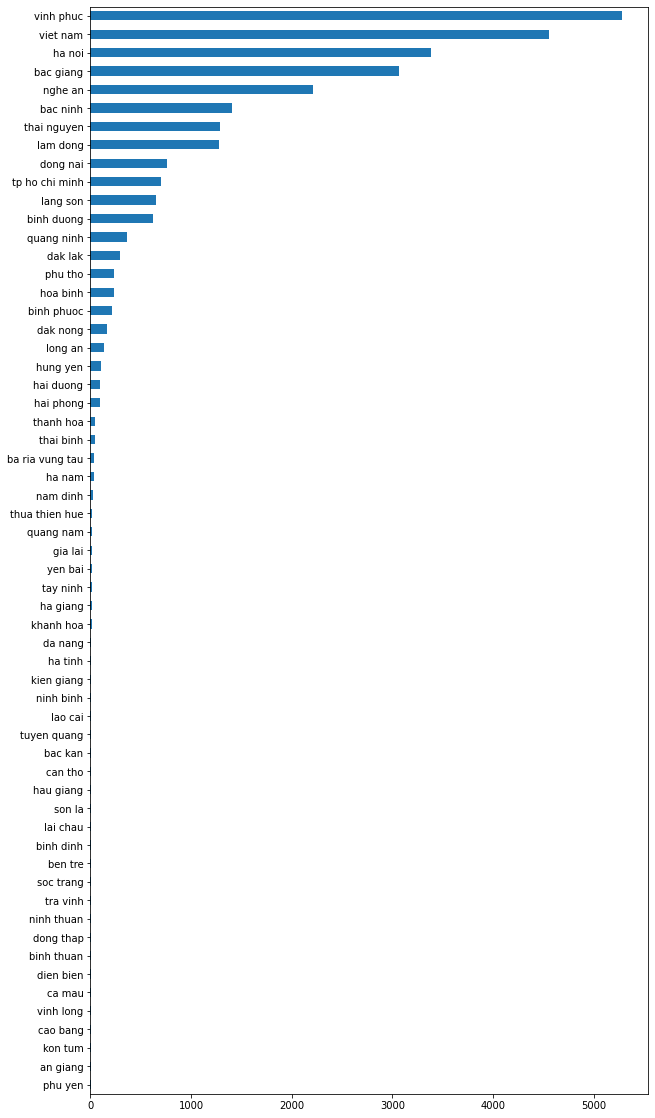

In [28]:
df["address"].value_counts().sort_values().plot(kind = 'barh', figsize=(10,20))

## Nghề nghiệp

In [29]:
def str_normalize(s):
    if type(s) == str:
        s = str(s).strip().lower()
        s = re.sub(' +', " ", s)
    return s

In [30]:
def job_category(job):
    if 'lai' in job or 'tai xe' in job:
        return 'tai xe'
    elif job.startswith(('giao vien','giang vien','tro giang','teacher','co ','gv','gioo vion','chu nhiem lop','g. vien','g.vien')):
        return 'giao vien'

    elif 'bep' in job:
        return 'dau bep'

    elif 'thu ky' in job or 'tro ly' in job or job.startswith(('thu ky','assistant',)):
        return 'tro ly'

    elif 'ca sy' in job or 'hoa sy' in job or 'dien vien' in job or job.startswith(('nhac','hoa si')):
        return 'nghe sy'

    elif 'bac si' in job or 'bac sy' in job or 'y ta' in job or job.startswith(('dieu duong','y sy','y i','nha si','nha sy','y te')):
        return 'y te'

    elif job.startswith(('ban')):
       return 'ban hang'
    elif 'truong phong' in job or 'giam doc' in job  \
            or 'giom doc' in job or 'chu tich' in job or 'vien truong' in job \
            or 'vien pho' in job or 'hieu truong' in job \
            or 'hieu pho' in job or job.startswith(('dao dien','bi thu','tong','pgd','gd','pho giam doc','quan doc','pho gd','ptgd','ptgd','uy vien','pho bi thu',
                                                                          'bt ','ct ', 'ct.','chi cuc','chu tich','tham phan ')) :
        return 'lanh dao'

    elif job.startswith(('quan ly','truong','doi truong','to truong','quan tri','pho','chi','chanh','phu trach','quan','tp','chu quan','chu nhiem','to pho','thanh tra')) or 'giam sat' in job or 'truong' in job:
        return 'quan ly'

    elif job.startswith(('chuyen gia','thac sỹ','thac si','tien si','tien sy','chuyen vien','kiem soat','co van','duoc ','chuyen gia ')):
        return 'chuyen gia'

    elif job.startswith(('cong an ','chien si','chien sy','trung ta','đai ta','truong cong an',)):
        return 'cong an, quan su'

    elif job.startswith(('cu nhan','ki thuat','lap trinh','admin','ky thuat','chuyen trach ','nghien cứu','bao tri','uy vien','kiem dinh','ki thuat','ky su','dai dien',
                                    'ky thuat','ki su','kinh doanh','giao dich','kiem sat','kiem pham','to chuc','tu phap','tham ','thong ke','chuan doan','kien truc','cong trinh','thiet ke',
                                    'dieu',)):
        return 'trinh do cao'

    elif job.startswith(('che bien','nhan vien san xuat')) :
        return 'san xuat'

    elif job.startswith(('truc ','thu kho','an ','bao ve',)):
        return 'bao ve'

    elif job.startswith(('ke toan','kiem tra','kiem thu','kiem hoa','kiem dich','kiem hang','kinh te vien','thu ngan','ket toan','van thu','thu quy','ke toan','bien')):
        return 'kinh te vien'

    elif job.startswith(('tiep vien','hanh chinh','tap vụ','nu ho sinh','nu ho sinh','mau dich','giao nhan','bhxh ','khuyen ','customer ''phien dich',
                                    'dia chinh','cham soc','bao mau','le tan','ho ly','huan luyen','dien thoai','tu van','ho tro','thuong ',)):
        return 'dich vu vien'

    elif job.startswith(('nhan vien','nv','nhon vion','cb','can bo','phuc vu','phuc vu','nhan vien','nhan vien',
                                    'cv','can su','hoc viec','thuc tap sinh','trung cap','vu','giao hang','trac dac','hlv','cong chuc','nhanvien','nhan  vien','nhiep anh',
                                    'ke hoach','kiem lam','hop dong','ho sinh','hat pho','ctv ','cao dang','can bo','tap ','thong '))  :
        return 'nhan vien'

    elif job.startswith(('tho ','cung nhon','cn','lao dong','thuy thu','cong nhan','boc xep','lao cong','ve sinh','may','lan','ld','lam','kho',
                                    'han ','gap xep','Coong nhaon','c«ng nh©n','con nhan','cong  nhan','thuyen ','sua ','cong nhan','san ','lap','khai thac','in ',
                                    'moi truong','ve sinh','sua','tho','cn','sua chua','may',)):
        return 'cong nhan'

    else: return 'khong ro'

In [31]:
def job_preprocess(x):
    x = str_normalize(x)
    x = job_category(x)
    return x

In [32]:
df["job/role"] = df["job/role"].apply(job_preprocess)

In [33]:
df_test["job/role"] = df_test["job/role"].apply(job_preprocess)

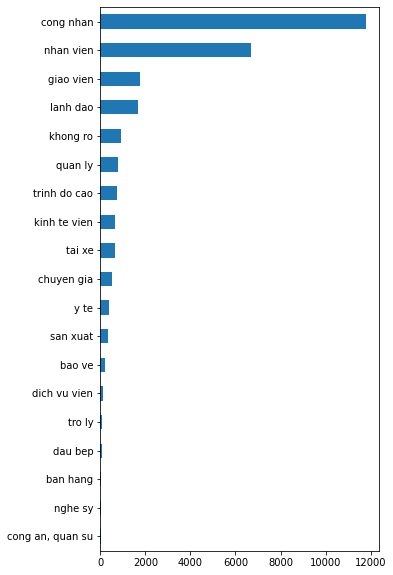

In [34]:
df["job/role"].value_counts().sort_values().plot(kind = 'barh', figsize=(5,10))

# Feature engineering

In [35]:
df.gender = pd.Categorical(df.gender)
df['gender_num'] = df.gender.cat.codes
df["id_office"] = df["id_office"].replace(np.nan, "ZZ000ZZ")
df["id_office_filter"] = df["id_office"].apply(lambda x: x[0:2])
df['age'] = 2022 - df['bithYear']

In [36]:
df_test.gender = pd.Categorical(df_test.gender)
df_test['gender_num'] = df_test.gender.cat.codes
df_test["id_office"] = df_test["id_office"].replace(np.nan, "ZZ000ZZ")
df_test["id_office_filter"] = df_test["id_office"].apply(lambda x: x[0:2])
df_test['age'] = 2022 - df_test['bithYear']

In [37]:
def split_year(string):
    return string[:4]

def split_month(string):
    return string[4:6]

def split_month_year(string):
    return str(string[:6])

In [38]:
df['from_date_new']= df['from_date'].astype('str').apply(split_month_year)
df['end_date_new']= df['to_date'].astype('str').apply(split_month_year)

df_test['from_date_new']= df_test['from_date'].astype('str').apply(split_month_year)
df_test['end_date_new']= df_test['to_date'].astype('str').apply(split_month_year)

In [39]:
df['exp'] = pd.to_datetime(df['end_date_new'].apply(str), format='%Y%m') - pd.to_datetime(df['from_date_new'].apply(str), format='%Y%m')
df['exp'] = df['exp'].dt.days

df_test['exp'] = pd.to_datetime(df_test['end_date_new'].apply(str), format='%Y%m') - pd.to_datetime(df_test['from_date_new'].apply(str), format='%Y%m')
df_test['exp'] = df_test['exp'].dt.days

In [40]:
del df['bithYear']
del df['gender']
del df['id_office']
del df['from_date']
del df['to_date']
del df['from_date_new']
del df['end_date_new']
del df['id']

del df_test['bithYear']
del df_test['gender']
del df_test['id_office']
del df_test['from_date']
del df_test['to_date']
del df_test['from_date_new']
del df_test['end_date_new']
del df_test['id']

In [41]:
df.head()

,id_bh,id_management,company_type,job/role,employee_lv,label,address,gender_num,id_office_filter,age,exp
0,113039360,106,-1,lanh dao,7.0,4,ha noi,1,TF,51,1064
1,116074930,102,-1,nhan vien,7.0,2,ha noi,0,TB,29,183
2,203060233,102,-1,kinh te vien,1.0,4,viet nam,1,CB,45,915
3,131373210,105,-1,dau bep,8.0,2,ha noi,0,TE,26,0
4,198079441,102,-1,cong nhan,-1.0,2,viet nam,1,TZ,51,5997


In [42]:
df_test.head()

,id_bh,id_management,company_type,job/role,employee_lv,address,gender_num,id_office_filter,age,exp
0,116303809,102,3,lanh dao,55.0,viet nam,0,IC,47,182
1,116301808,102,-1,nhan vien,8.0,ha noi,1,TB,51,1064
2,131644973,102,6,chuyen gia,59.0,ha noi,1,IC,33,853
3,131264273,2706,-1,nhan vien,7.0,bac ninh,0,TF,39,30
4,113003795,100,6,chuyen gia,-1.0,ha noi,1,HW,60,2892


# Mô hình

In [44]:
le = preprocessing.LabelEncoder()
df['job/role'] = le.fit_transform(df['job/role'])
df['address'] = le.fit_transform(df['address'])
df['id_office_filter'] = le.fit_transform(df['id_office_filter'])

df_test['job/role'] = le.fit_transform(df_test['job/role'])
df_test['address'] = le.fit_transform(df_test['address'])
df_test['id_office_filter'] = le.fit_transform(df_test['id_office_filter'])

In [51]:
df_test.head()

,id_bh,id_management,company_type,job/role,employee_lv,address,gender_num,id_office_filter,age,exp,label
0,116303809,102,3,10,55.0,53,0,93,47,182,5
1,116301808,102,-1,12,8.0,20,1,144,51,1064,2
2,131644973,102,6,2,59.0,20,1,93,33,853,5
3,131264273,2706,-1,12,7.0,3,0,148,39,30,2
4,113003795,100,6,2,-1.0,20,1,89,60,2892,5


In [48]:
X_train = df[['id_management', 'company_type', 'job/role', 'employee_lv', 'address', 'gender_num', 'id_office_filter', 'age', 'exp']]
Y_train = df[['label']]

X_test = df_test[['id_management', 'company_type', 'job/role', 'employee_lv', 'address', 'gender_num', 'id_office_filter', 'age', 'exp']]

In [49]:
params = {
            'max_depth': 4,
            'alpha': 0.1,
            'learning_rate': 0.005,
            'n_estimators':100
        }         
           
xgb_clf = XGBClassifier(**params)
xgb_clf.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(alpha=0.1, learning_rate=0.005, max_depth=4,
              objective='multi:softprob')

In [50]:
df_test['label'] = xgb_clf.predict(X_test)

In [53]:
output = df_test[['id_bh', 'label']]

In [55]:
output.to_csv("/content/submission.csv", index=False)